In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg
from tqdm.notebook import tqdm

import jax
import jax.numpy as jnp

In [2]:
import sys
sys.path.append("../..")

from adversarial_ntks import attacks

In [3]:
np.random.seed(42)

## Generating data

We sample two Gaussians in $D$ dimensions with standard deviations $\sigma_0$ and $\sigma_1$.

The radii of the two Gaussians are thus $R_i = \sigma_i \cdot \sqrt{D}$.

In [4]:
def normalize(xs: np.ndarray, norm):
    norm_xs = xs / np.linalg.norm(xs, axis=-1, ord=norm).reshape(-1, 1)
    return norm_xs

def gen_data(d, r0, r1, num_samples):
    sigma0, sigma1 = r0 / np.sqrt(d), r1 / np.sqrt(d)
    
    xs0 = np.random.normal(size=(num_samples, d), scale=sigma0)
    xs1 = np.random.normal(size=(num_samples, d), scale=sigma1)
    
    return xs0, xs1

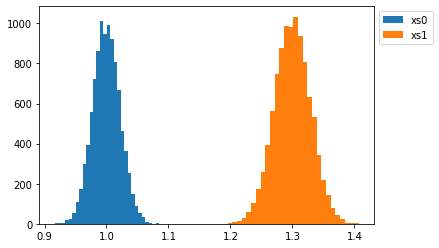

In [5]:
# The standard experimental parameters for this notebook
_D = 1000
_R0, _R1 = 1.0, 1.3
_SIGMA0, _SIGMA1 = _R0 / np.sqrt(_D), _R1 / np.sqrt(_D)
_COV0, _COV1 = _SIGMA0 ** 2 * np.eye(_D), _SIGMA1 ** 2 * np.eye(_D)
_NUM_SAMPLES = 10 ** 4
_XS0, _XS1 = gen_data(d=_D, r0=_R0, r1=_R1, num_samples=_NUM_SAMPLES)
_XS0_TEST, _XS1_TEST = gen_data(d=_D, r0=_R0, r1=_R1, num_samples=2048)
# DO NOT MUTATE after this point

plt.hist(np.linalg.norm(_XS0, ord=2, axis=-1), bins=30, label="xs0");
plt.hist(np.linalg.norm(_XS1, ord=2, axis=-1), bins=30, label="xs1");
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1);

## Learning the mean
We use the sample mean $\hat{\mu} = \frac{1}{n} \sum_{i = 1}^n x_i$.

In [6]:
def est_mean(xs):
    return xs.mean(axis=0)

xs0, xs1 = gen_data(
    d=1000, r0=1.0, r1=1.3, num_samples=10 ** 4
)
muh0, muh1 = est_mean(xs0), est_mean(xs1)
np.linalg.norm(muh0), np.linalg.norm(muh1)

(0.009758601795447665, 0.012534289686301825)

In 1000 dimensions with $R_0 = 1$ and $R_1 = 1.3$ and 10k samples,
our estimated means are off by ~1e-2, which is accurate enough for robust classification.

## Learning covariance (assuming zero mean)
We use the empirical covariance.
$$\hat{\Sigma} = \frac{1}{n} \sum_{i=1}^n x_i x_i^\top.$$

In [7]:
def est_cov(xs):
    num_samples = xs.shape[0]
    return (xs.T @ xs) / num_samples

covh0, covh1 = est_cov(_XS0), est_cov(_XS1)
covh0.shape, covh1.shape

((1000, 1000), (1000, 1000))

#### Learned covariances: eigenvalues

They eigenvalues values of $\hat{\Sigma}_i$ are concentrated around $\sigma_i^2$,
and take a [Marchenko–Pastur distribution](https://en.wikipedia.org/wiki/Marchenko%E2%80%93Pastur_distribution).

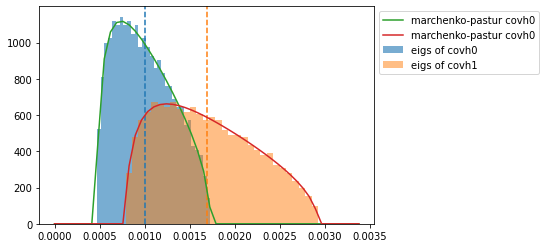

In [8]:
def hist_eigs(hmat, **kwargs):
    """hmat a hermitian matrix"""
    svs = np.linalg.eigvalsh(hmat)
    plt.hist(svs, **kwargs)
    
def mp_density(sig, lam, xs):
    """For square matrices"""
    assert lam <= 1
    sig2 = sig ** 2
    llo = sig2 * (1 - np.sqrt(lam)) ** 2
    lhi = sig2 * (1 + np.sqrt(lam)) ** 2
    
    xs_safe = xs.copy()
    xs_safe[xs < llo] = llo
    xs_safe[xs > lhi] = lhi
    
    ds = (
        1 / (2 * np.pi * sig2)
        * np.sqrt((lhi - xs_safe) * (xs_safe - llo))
        / lam / xs_safe
    )
    ds[xs < llo] = 0
    ds[xs > lhi] = 0
    return ds
    
hist_eigs(covh0, label="eigs of covh0", bins=30, density=True, alpha=0.6)
hist_eigs(covh1, label="eigs of covh1", bins=30, density=True, alpha=0.5)

plt.axvline(_SIGMA0 ** 2, color="C0", ls="--");
plt.axvline(_SIGMA1 ** 2, color="C1", ls="--");

mp_pts = np.linspace(0, 2 * _SIGMA1 ** 2)
plt.plot(mp_pts, mp_density(sig=_SIGMA0, lam=_D/_NUM_SAMPLES, xs=mp_pts), label="marchenko-pastur covh0")
plt.plot(mp_pts, mp_density(sig=_SIGMA1, lam=_D/_NUM_SAMPLES, xs=mp_pts), label="marchenko-pastur covh0")

plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1);

#### Learned covariances: eigenvalues values Mk. 2
This time we first transform coordinates such that $\hat{\Sigma}_0$ is the identity matrix.
We then plot the eigenvalues of $\hat{\Sigma}_1$.

In the infinite sample regime, the eigenvalues of $\hat{\Sigma}_1$ with respect to $\hat{\Sigma}_0$
should be concentrated around $(\sigma_1 / \sigma_0)^2$.

We also plot to the reverse.

In [9]:
def normalize_wrt(target: np.ndarray, base: np.ndarray):
    """
    target and base are square symmetric matrices.
    This function transforms coordinates so that base is the identity,
    then returns target in the transformed coordinates.
    """
    isqrt_base = np.linalg.inv(scipy.linalg.sqrtm(base))
    return isqrt_base @ target @ isqrt_base

# Check normalize_wrt returns the identity when target=base
np.allclose(
    normalize_wrt(target=covh0, base=covh0),
    np.eye(covh1.shape[0])
)

True

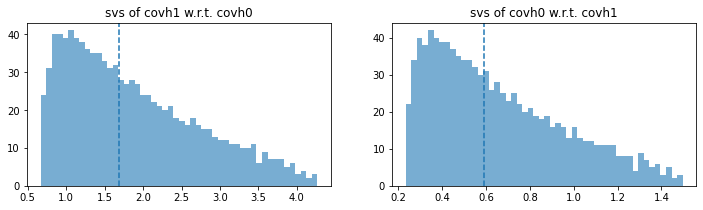

In [10]:
plt.figure(figsize=(12,3))

plt.subplot(1, 2, 1)
hist_eigs(normalize_wrt(target=covh1, base=covh0), bins=50, alpha=0.6)
plt.axvline((_SIGMA1 / _SIGMA0) ** 2, color="C0", ls="--");
plt.title("svs of covh1 w.r.t. covh0");

plt.subplot(1, 2, 2)
hist_eigs(normalize_wrt(target=covh0, base=covh1), bins=50, alpha=0.6)
plt.axvline((_SIGMA0 / _SIGMA1) ** 2, color="C0", ls="--");
plt.title("svs of covh0 w.r.t. covh1");

#### Learned covariances: eigenvalues values Mk. 3
One of the key quantities in the LRT is the matrix $\Delta = \Sigma_0^{-1} - \Sigma_1^{-1}$.

The eigvanlues of $\Delta$ should be concentrated around $\sigma_0^{-2} - \sigma_1^{-2}$.

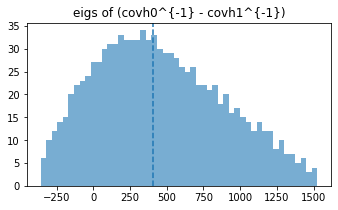

In [11]:
plt.figure(figsize=(12,3))

plt.subplot(1, 2, 1)
hist_eigs(np.linalg.inv(covh0) - np.linalg.inv(covh1), bins=50, alpha=0.6)
plt.axvline((_SIGMA0 ** -2) - (_SIGMA1 ** -2), color="C0", ls="--");
plt.title("eigs of (covh0^{-1} - covh1^{-1})");

# Performance of likelihood-ratio test
This test assumes each class conditional distribution is
$\mathcal{N}(\hat{\mu}, \hat{\Sigma})$.

Thus the optimal test (for natural accuracy) takes the form
(predicting 1 when the below condition is true)
$$
\log \,\left|\hat{\Sigma}_0\right| + (x-\hat{\mu}_0)^\top \hat{\Sigma}_0^{-1} (x-\hat{\mu}_0)^\top
> \log \,\left|\hat{\Sigma}_1\right| + (x-\hat{\mu}_1)^\top \hat{\Sigma}_1^{-1} (x-\hat{\mu}_1)^\top
$$
which is equivalent to
$$
x^\top \left(\hat{\Sigma}_0^{-1} - \hat{\Sigma}_1^{-1}\right) x
- 2\left(\hat{\Sigma}_0^{-1} \hat{\mu}_0 - \hat{\Sigma}_1^{-1} \hat{\mu}_1 \right)^\top x
+ \log \,\left|\hat{\Sigma}_0\right| - \log \,\left|\hat{\Sigma}_1\right|
> 0
$$
In the known zero-mean case (i.e. $\hat{\mu}_0 = \hat{\mu}_1 = 0$), this reduces to
$$
x^\top \left(\hat{\Sigma}_0^{-1} - \hat{\Sigma}_1^{-1}\right) x
+ \log \,\left|\hat{\Sigma}_0\right| - \log \,\left|\hat{\Sigma}_1\right|
> 0
$$

In [168]:
@jax.jit
def gaussian_log_likelihood(
    xs: np.ndarray,
    mu: np.ndarray,
    cov: np.ndarray,
):
    """
    xs of shape (num_samples, dim)
    cov of shape (dim, dim)
    return shape: (num_samples, )
    """
    icov = jnp.linalg.inv(cov)
    return (
        - 0.5 * jnp.linalg.slogdet(cov)[1]
        - 0.5 * jnp.einsum("ij,jk,ki->i", (xs - mu), icov, (xs - mu).T, optimize=True)
    )

@jax.jit
def gaussian_ll_diffs(xs, mu0, mu1, cov0, cov1):
    ll0 = gaussian_log_likelihood(xs, mu=mu0, cov=cov0)
    ll1 = gaussian_log_likelihood(xs, mu=mu1, cov=cov1)
    ll_diffs = ll1 - ll0
    return ll_diffs

def gaussian_lr_predict(xs, mu0, mu1, cov0, cov1, thresh=0):
    """
    Likelihood ratio test classification
    Returns preds, diffs
    """
    diffs = gaussian_ll_diffs(xs, mu0=mu0, mu1=mu1, cov0=cov0, cov1=cov1)
    return (diffs >= thresh).astype(int)

## Behavior of LRT vs. radius

In [169]:
def cls1_frac_by_rad(
    classifier,
    rads: np.ndarray,
    dim: int,
    num_samples_per_rad=256,
):    
    cls1_fracs = np.zeros_like(rads)
    for idx, r in enumerate(tqdm(rads, leave=False)):
        xs = r * normalize(
            xs=np.random.normal(size=(num_samples_per_rad, dim)),
            norm=2
        )

        preds = classifier(xs)
        cls1_fracs[idx] = (preds == 1).mean()
        
    return cls1_fracs

**First the case where we know the true mean and covariance.**

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

CPU times: user 1min 31s, sys: 41.8 s, total: 2min 13s
Wall time: 17.5 s


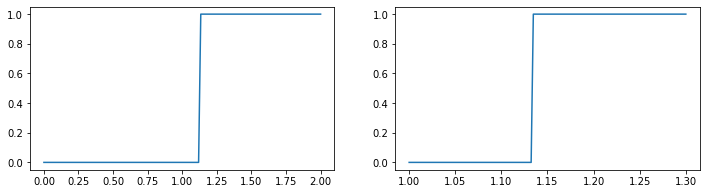

In [170]:
%%time
covh0, covh1 = est_cov(_XS0), est_cov(_XS1)

plt.figure(figsize=(12, 3))

plt.subplot(1, 2, 1)
rads = np.linspace(start=0, stop=2, num=128)
cls1_fracs = cls1_frac_by_rad(
    rads=rads, dim=_D,
    classifier=lambda xs: gaussian_lr_predict(xs, mu0=0, mu1=0, cov0=_COV0, cov1=_COV1)
)
plt.plot(rads, cls1_fracs);

plt.subplot(1, 2, 2)
rads = np.linspace(start=1.0, stop=1.3, num=128)
cls1_fracs = cls1_frac_by_rad(
    rads=rads, dim=_D,
    classifier=lambda xs: gaussian_lr_predict(xs, mu0=0, mu1=0, cov0=_COV0, cov1=_COV1)
)
plt.plot(rads, cls1_fracs);

We note that the optimal decision boundary for natural accuracy
is slightly smaller than the optimal decision boundary for L2 robust accuracy.

**Now the case with learned means and covariances.**

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

CPU times: user 1min 33s, sys: 41.3 s, total: 2min 15s
Wall time: 17.9 s


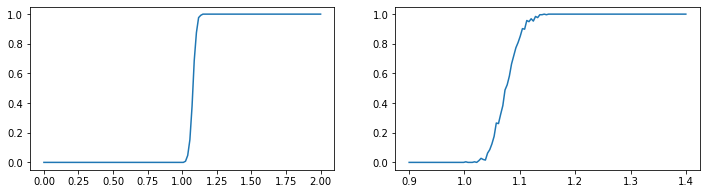

In [15]:
%%time
plt.figure(figsize=(12, 3))

muh0, muh1 = est_mean(_XS0), est_mean(_XS1)
covh0, covh1 = est_cov(_XS0), est_cov(_XS1)

plt.subplot(1, 2, 1)
rads = np.linspace(start=0, stop=2, num=128)
cls1_fracs = cls1_frac_by_rad(
    rads=rads, dim=_D,
    classifier=lambda xs: gaussian_lr_predict(xs, mu0=muh0, mu1=muh0, cov0=covh0, cov1=covh1)
)
plt.plot(rads, cls1_fracs);

plt.subplot(1, 2, 2)
rads = np.linspace(start=0.9, stop=1.4, num=128)
cls1_fracs = cls1_frac_by_rad(
    rads=rads, dim=_D,
    classifier=lambda xs: gaussian_lr_predict(xs, mu0=muh0, mu1=muh0, cov0=covh0, cov1=covh1)
)
plt.plot(rads, cls1_fracs);

Class 1 has a lot of buffer. Class 0 not so much.

## Natural accuracy

In [181]:
covh0, covh1 = est_cov(_XS0), est_cov(_XS1)
preds0 = gaussian_lr_predict(_XS0_TEST, mu0=0, mu1=0, cov0=covh0, cov1=covh1)
preds1 = gaussian_lr_predict(_XS1_TEST, mu0=0, mu1=0, cov0=covh0, cov1=covh1)

print(f"preds0 acc: {(preds0 == 0).mean()}")
print(f"preds1 acc: {(preds1 == 1).mean()}")

preds0 acc: 0.99365234375
preds1 acc: 1.0


In [182]:
covh0, covh1 = est_cov(_XS0), est_cov(_XS1)
preds0 = gaussian_lr_predict(_XS0_TEST, mu0=0, mu1=0, cov0=_COV0, cov1=_COV1)
preds1 = gaussian_lr_predict(_XS1_TEST, mu0=0, mu1=0, cov0=_COV0, cov1=_COV1)

print(f"preds0 acc: {(preds0 == 0).mean()}")
print(f"preds1 acc: {(preds1 == 1).mean()}")

preds0 acc: 1.0
preds1 acc: 1.0


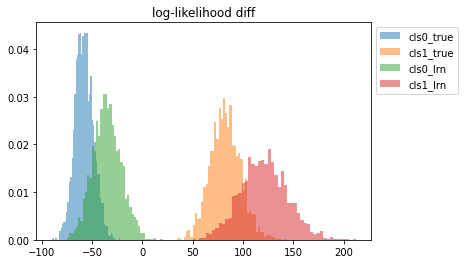

In [185]:
plt.title("log-likelihood diff")
plt.hist(gaussian_ll_diffs(_XS0_TEST, mu0=0, mu1=0, cov0=_COV0, cov1=_COV1), density=True, bins=50, label="cls0_true", alpha=0.5)
plt.hist(gaussian_ll_diffs(_XS1_TEST, mu0=0, mu1=0, cov0=_COV0, cov1=_COV1), density=True, bins=50, label="cls1_true", alpha=0.5)

plt.hist(gaussian_ll_diffs(_XS0_TEST, mu0=0, mu1=0, cov0=covh0, cov1=covh1), density=True, bins=50, label="cls0_lrn", alpha=0.5)
plt.hist(gaussian_ll_diffs(_XS1_TEST, mu0=0, mu1=0, cov0=covh0, cov1=covh1), density=True, bins=50, label="cls1_lrn", alpha=0.5)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1);

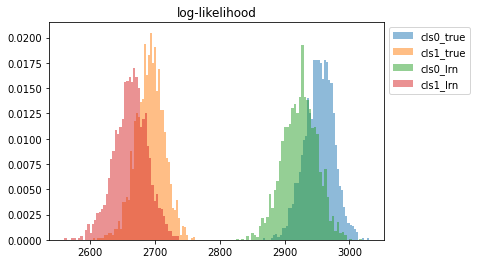

In [190]:
plt.title("log-likelihood")
plt.hist(gaussian_log_likelihood(_XS0_TEST, mu=0, cov=_COV0), density=True, bins=50, label="cls0_true", alpha=0.5)
plt.hist(gaussian_log_likelihood(_XS1_TEST, mu=0, cov=_COV1), density=True, bins=50, label="cls1_true", alpha=0.5)

plt.hist(gaussian_log_likelihood(_XS0_TEST, mu=0, cov=covh0), density=True, bins=50, label="cls0_lrn", alpha=0.5)
plt.hist(gaussian_log_likelihood(_XS1_TEST, mu=0, cov=covh1), density=True, bins=50, label="cls1_lrn", alpha=0.5)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1);

## Adversarial accuracy

### Radial perturbation

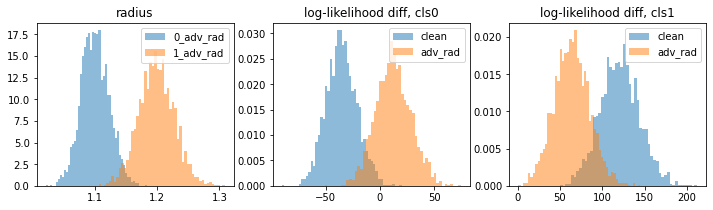

In [156]:
eps = 0.1
xs0_adv_rad = _XS0_TEST + eps * normalize(_XS0_TEST, norm=2)
xs1_adv_rad = _XS1_TEST - eps * normalize(_XS1_TEST, norm=2)

plt.figure(figsize=(12, 3))

plt.subplot(1, 3, 1)
plt.title("radius")
plt.hist(np.linalg.norm(xs0_adv_rad, ord=2, axis=-1), density=True, bins=50, label="0_adv_rad", alpha=0.5);
plt.hist(np.linalg.norm(xs1_adv_rad, ord=2, axis=-1), density=True, bins=50, label="1_adv_rad", alpha=0.5);
plt.legend();

plt.subplot(1, 3, 2)
plt.title("log-likelihood diff, cls0")
plt.hist(gaussian_ll_diffs(_XS0_TEST, mu0=0, mu1=0, cov0=covh0, cov1=covh1), density=True, bins=50, label="clean", alpha=0.5)
plt.hist(gaussian_ll_diffs(xs0_adv_rad, mu0=0, mu1=0, cov0=covh0, cov1=covh1), density=True, bins=50, label="adv_rad", alpha=0.5)
plt.legend();

plt.subplot(1, 3, 3)
plt.title("log-likelihood diff, cls1")
plt.hist(gaussian_ll_diffs(_XS1_TEST, mu0=0, mu1=0, cov0=covh0, cov1=covh1), density=True, bins=50, label="clean", alpha=0.5)
plt.hist(gaussian_ll_diffs(xs1_adv_rad, mu0=0, mu1=0, cov0=covh0, cov1=covh1), density=True, bins=50, label="adv_rad", alpha=0.5);
plt.legend();

In [175]:
covh0, covh1 = est_cov(_XS0), est_cov(_XS1)

preds0 = gaussian_lr_predict(xs0_adv_rad, mu0=0, mu1=0, cov0=covh0, cov1=covh1)
preds1 = gaussian_lr_predict(xs1_adv_rad, mu0=0, mu1=0, cov0=covh0, cov1=covh1)

print(f"preds0 adv acc: {(preds0 == 0).mean()}")
print(f"preds1 adv acc: {(preds1 == 1).mean()}")

preds0 adv acc: 0.2255859375
preds1 adv acc: 1.0


##### Perfect classifier

In [158]:
preds0 = gaussian_lr_predict(xs0_adv_rad, mu0=0, mu1=0, cov0=_COV0, cov1=_COV1)
preds1 = gaussian_lr_predict(xs1_adv_rad, mu0=0, mu1=0, cov0=_COV0, cov1=_COV1)

print(f"preds0 adv acc: {(preds0 == 0).mean()}")
print(f"preds1 adv acc: {(preds1 == 1).mean()}")

preds0 adv acc: 0.9248046875
preds1 adv acc: 0.98828125


### Worst eigenvalue perturbation
This attack doesn't work too well.

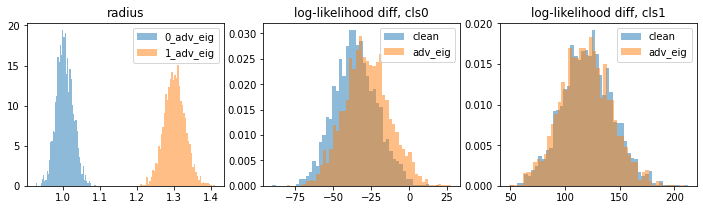

In [160]:
covh0, covh1 = est_cov(_XS0), est_cov(_XS1)

diff = np.linalg.inv(covh0) - np.linalg.inv(covh1)
diff_eigs, diff_eigvcts = np.linalg.eigh(diff)

eps = 0.1
xs0_adv_eig = _XS0_TEST + eps * diff_eigvcts[:, -1]
xs1_adv_eig = _XS1_TEST + eps * diff_eigvcts[:, 0]

plt.figure(figsize=(12, 3))

plt.subplot(1, 3, 1)
plt.title("radius")
plt.hist(np.linalg.norm(xs0_adv_eig, ord=2, axis=-1), density=True, bins=50, label="0_adv_eig", alpha=0.5);
plt.hist(np.linalg.norm(xs1_adv_eig, ord=2, axis=-1), density=True, bins=50, label="1_adv_eig", alpha=0.5);
plt.legend();

plt.subplot(1, 3, 2)
plt.title("log-likelihood diff, cls0")
plt.hist(gaussian_ll_diffs(_XS0_TEST, mu0=0, mu1=0, cov0=covh0, cov1=covh1), density=True, bins=50, label="clean", alpha=0.5)
plt.hist(gaussian_ll_diffs(xs0_adv_eig, mu0=0, mu1=0, cov0=covh0, cov1=covh1), density=True, bins=50, label="adv_eig", alpha=0.5)
plt.legend();

plt.subplot(1, 3, 3)
plt.title("log-likelihood diff, cls1")
plt.hist(gaussian_ll_diffs(_XS1_TEST, mu0=0, mu1=0, cov0=covh0, cov1=covh1), density=True, bins=50, label="clean", alpha=0.5)
plt.hist(gaussian_ll_diffs(xs1_adv_eig, mu0=0, mu1=0, cov0=covh0, cov1=covh1), density=True, bins=50, label="adv_eig", alpha=0.5);
plt.legend();

In [161]:
preds0 = gaussian_lr_predict(xs0_adv_eig, mu0=0, mu1=0, cov0=covh0, cov1=covh1)
preds1 = gaussian_lr_predict(xs1_adv_eig, mu0=0, mu1=0, cov0=covh0, cov1=covh1)

print(f"preds0 adv acc: {(preds0 == 0).mean()}")
print(f"preds1 adv acc: {(preds1 == 1).mean()}")

preds0 adv acc: 0.95947265625
preds1 adv acc: 1.0


### PGD

In [151]:
def tot_gaussian_ll_diff(X, mu0, mu1, cov0, cov1):
    return gaussian_ll_diffs(X, mu0=mu0, mu1=mu1, cov0=cov0, cov1=cov1).sum()

grad_tot_gaussian_ll_diff = jax.jit(jax.grad(tot_gaussian_ll_diff))

In [165]:
%%time

covh0, covh1 = est_cov(_XS0), est_cov(_XS1)

eps = 0.1

xs0_adv_pgd = attacks.pgd(
    X=_XS0_TEST,
    Y=np.zeros(_XS0_TEST.shape[0]),
    grad_func=lambda X: grad_tot_gaussian_ll_diff(X, 0, 0, covh0, covh1),
    eps=eps,
    eps_norm=2,
    num_steps=20,
    step_size=eps / 10,
    step_norm=2,
    pixel_clip=False
)

xs1_adv_pgd = attacks.pgd(
    X=_XS1_TEST,
    Y=np.ones(_XS0_TEST.shape[0]),
    grad_func=lambda X: grad_tot_gaussian_ll_diff(X, 0, 0, covh0, covh1),
    eps=eps,
    eps_norm=2,
    num_steps=20,
    step_size=eps / 10,
    step_norm=2,
    pixel_clip=False
)

CPU times: user 1min 6s, sys: 15.7 s, total: 1min 22s
Wall time: 8.59 s


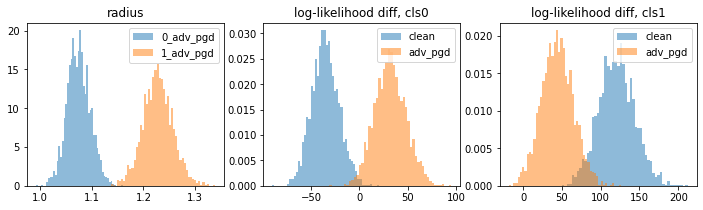

In [166]:
plt.figure(figsize=(12, 3))

plt.subplot(1, 3, 1)
plt.title("radius")
plt.hist(np.linalg.norm(xs0_adv_pgd, ord=2, axis=-1), density=True, bins=50, label="0_adv_pgd", alpha=0.5);
plt.hist(np.linalg.norm(xs1_adv_pgd, ord=2, axis=-1), density=True, bins=50, label="1_adv_pgd", alpha=0.5);
plt.legend();

plt.subplot(1, 3, 2)
plt.title("log-likelihood diff, cls0")
plt.hist(gaussian_ll_diffs(_XS0_TEST, mu0=0, mu1=0, cov0=covh0, cov1=covh1), density=True, bins=50, label="clean", alpha=0.5)
plt.hist(gaussian_ll_diffs(xs0_adv_pgd, mu0=0, mu1=0, cov0=covh0, cov1=covh1), density=True, bins=50, label="adv_pgd", alpha=0.5)
plt.legend();

plt.subplot(1, 3, 3)
plt.title("log-likelihood diff, cls1")
plt.hist(gaussian_ll_diffs(_XS1_TEST, mu0=0, mu1=0, cov0=covh0, cov1=covh1), density=True, bins=50, label="clean", alpha=0.5)
plt.hist(gaussian_ll_diffs(xs1_adv_pgd, mu0=0, mu1=0, cov0=covh0, cov1=covh1), density=True, bins=50, label="adv_pgd", alpha=0.5);
plt.legend();

In [173]:
preds0 = gaussian_lr_predict(xs0_adv_pgd, mu0=0, mu1=0, cov0=covh0, cov1=covh1, thresh=25)
preds1 = gaussian_lr_predict(xs1_adv_pgd, mu0=0, mu1=0, cov0=covh0, cov1=covh1, thresh=25)

print(f"preds0 adv acc: {(preds0 == 0).mean()}")
print(f"preds1 adv acc: {(preds1 == 1).mean()}")

preds0 adv acc: 0.3310546875
preds1 adv acc: 0.82373046875
